# Building Better Models for Inference:

# How to construct practical models for existing tools

In this notebook, we will walk through fitting an observed optical light curve from a tidal disruption event (TDE), the destruction and accretion of a star by a supermassive black hole, using two different approaches.

As mentioned in the lecture, there are different kinds of models one can apply to a set of data. A code I have written, MOSFiT, is an attempt to provide a framework for building models that can be used within other optimizers/samplers. While MOSFiT can run independently with its own built-in samplers, in the notebook below we will simple be using it as a "black box" function for use in external optimization routines.

Our first approach will be using the `tde` model in MOSFiT. This model uses both interpolation tables and integrations, making an analytical derivative not available. Our second approach will be to construct a simple analytical function to fit the same data. We will then be comparing performance, both in terms of the quality of the resulting solution, but also the speed by which the solution was computed, and in how we relate our solution to what transpired in this event.

* * *

By J Guillochon (Harvard)

*We will be mostly using the mosfit package and scipy routines. Both are available via conda.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mosfit
import time

# Disable "retina" line below if your monitor doesn't support it.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Problem 1) Fitting data with a blackbox model

In this first cell, we load the data of a particularly well-sampled tidal disruption event from the Pan-STARRS survey, PS1-10jh. This even is notable because it was caught on the rise, peak, and decay, with solid cadence.

The datafile can be aquired from https://northwestern.app.box.com/s/ekwpbf8ufe1ivogpxq9yyex302zx0t96.

In [2]:
# Load the data from the Open Supernova Catalog.
# Note: if loading the data doesn't work, I have a local copy.
my_printer = mosfit.printer.Printer(quiet=True)  # just to avoid spamming from MOSFiT routines.
my_fetcher = mosfit.fetcher.Fetcher()

fetched = my_fetcher.fetch('PS1-10jh.json')[0]

my_model = mosfit.model.Model(model='tde', printer=my_printer)
fetched_data = my_fetcher.load_data(fetched)
my_model.load_data(
    fetched_data, event_name=fetched['name'],
    exclude_bands=['u', 'r', 'i', 'z', 'F225W', 'NUV'],  # ignore all bands but g when computing ln_likelihood.
    smooth_times=100,  # for plotting smooth fits later
    user_fixed_parameters=['covariance'])  # don't use GP objective function.

# Generate 100 random parameter realizations.
x = np.random.rand(100, my_model.get_num_free_parameters())

# Compute time per function call.
start_time = time.time()
ln_likes = [my_model.ln_likelihood(xx) for xx in x]
stop_time = time.time()

print('{}s per function call.'.format((stop_time - start_time)/100.0))


Event file:
  PS1-10jh.json
0.011465511322021484s per function call.


**Problem 1a**

First, let's visualize the data we have downloaded. MOSFiT loads data in a format conforming to the OAC schema specification, which is a JSON dictionary where the top level of the structure is each event's name. The code snippet below will load a JSON dictionary for the event in question, plot the full time series of photometric data (with error bars) within the `photometry` key below.

*Hint: The photometry is a mixture of different data types, and not every entry has the same set of keys. Optical/UV/IR photometry will always have a `band` key. Ignore upper limits (indicated with the `upperlimit` attribute). Use the `.get()` function liberally, and make sure everything is a `float`!*

OrderedDict([('time', ['56833.1', '56833.100']), ('countrate', '0.671'), ('e_countrate', '0.396'), ('e_lower_flux', '9.72E-13'), ('e_lower_luminosity', '8.16E+43'), ('e_upper_flux', '3.80E-12'), ('e_upper_luminosity', '3.19E+44'), ('energy', ['0.3', '2.0']), ('flux', '2.38E-12'), ('instrument', 'PN'), ('luminosity', '2.00E+44'), ('nhmw', '0.0129'), ('photonindex', '4.5'), ('telescope', 'XMM'), ('u_countrate', 's^-1'), ('u_energy', 'keV'), ('u_flux', 'ergs/cm^2/s'), ('u_time', 'MJD'), ('source', '1')])


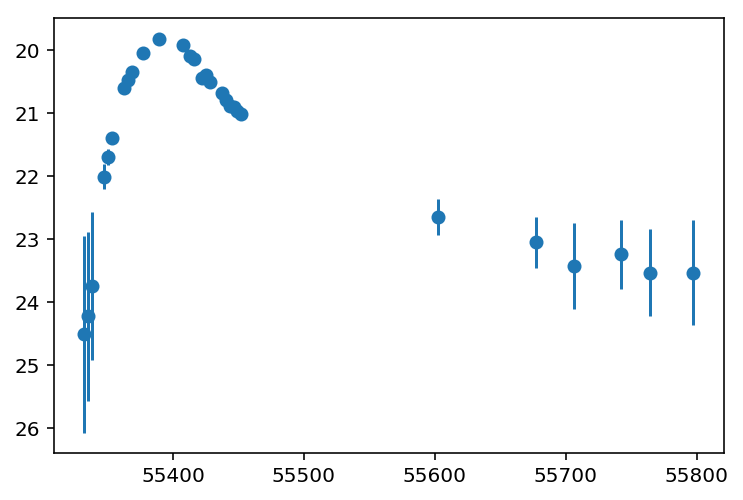

In [44]:
times = []
mags = []
errs = []
for x in fetched_data[fetched['name']]['photometry']:
    #print(x)
    if x.get('upperlimit') or x.get('band')!='g' or not x.get('e_magnitude'):
        continue
    t=np.mean(np.array(x['time']).astype(float))
    times.append(t)
    mags.append(float(x['magnitude']))
    errs.append(float(x['e_magnitude']))
#print(x)
        
    
plt.errorbar(times, mags, yerr=errs, fmt='o')
plt.gca().invert_yaxis()
plt.show()

In [40]:
print(len(times))

29


**Problem 1b**

We know what the data looks like, and we've loaded a model that can be used to fit the data which computes a likelihood. Let's minimize the parameters of this model using various `scipy.optimize` routines. Note that since we are trying to **maximize** the likelihood, we have constructed a wrapper function around `ln_likelihood`, `my_func`, to reverse its sign, and to handle bad function evaluations.

Most `optimize` routines in `scipy` require a derivative. Since we don't have this available, `scipy` must construct an approximate one, unless the method doesn't require a gradient to be computed (like `differential_evolution`). For this first sub-problem, optimize `my_func` using `differential_evolution`.

*Hints: Each variable is bounded to the range (0, 1), but problems can arise if an optimizer attempts to compute values outside or right at the boundaries. Therefore, it is recommended to use a bounded optimizer in `scipy`, where the bounds do **not include** 0 or 1.*

In [47]:
import scipy

def my_func(x):
    try:
        fx = -float(my_model.ln_likelihood(x))
    except:
        fx = np.inf
    return fx

eps = 0.00001
bounds = np.full((my_model.get_num_free_parameters(),2),(eps,1.0-eps))
# print(bounds)
results = scipy.optimize.differential_evolution(my_func,bounds,disp=True,polish=False,maxiter=100)  # complete
best_x = results.x

print('All done! Best score: `{}`.'.format(-results.fun))

differential_evolution step 1: f(x)= 32.204
differential_evolution step 2: f(x)= 23.35
differential_evolution step 3: f(x)= 23.35
differential_evolution step 4: f(x)= 23.35
differential_evolution step 5: f(x)= 23.35
differential_evolution step 6: f(x)= 23.35
differential_evolution step 7: f(x)= 22.9342
differential_evolution step 8: f(x)= 22.9342
differential_evolution step 9: f(x)= 21.755
differential_evolution step 10: f(x)= 9.00181
differential_evolution step 11: f(x)= 9.00181
differential_evolution step 12: f(x)= 9.00181
differential_evolution step 13: f(x)= 9.00181
differential_evolution step 14: f(x)= 9.00181
differential_evolution step 15: f(x)= 9.00181
differential_evolution step 16: f(x)= 9.00181
differential_evolution step 17: f(x)= 9.00181
differential_evolution step 18: f(x)= 9.00181
differential_evolution step 19: f(x)= 9.00181
differential_evolution step 20: f(x)= 9.00181
differential_evolution step 21: f(x)= 9.00181
differential_evolution step 22: f(x)= 9.00181
different

This might take a while; try to limit the execution time of the above to ~5 minutes by playing with the `maxiter` and similar options of the `scipy` optimizers.

Once the above has finished evaluating, compare the score you got to your neighbors. Is there a significant difference between your scores? Let's plot your result against the data.

Model output is provided in the `output` object below, the format is a dictionary of arrays of the same length. The times of observation are in the `times` array, and magnitudes are in the `model_observations` array.

*Hint: `times` is given relative to the time of the first detection, so add `min(times)` to your time to overplot onto the data.*

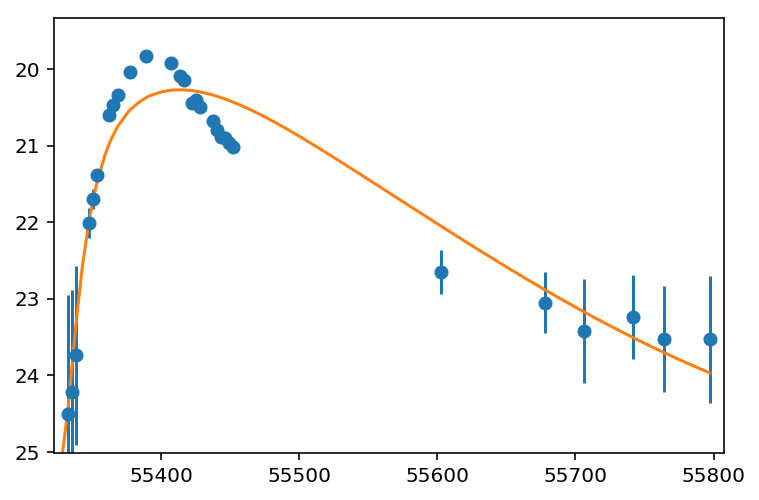

In [52]:
output = my_model.run_stack(best_x, root='output')

mtimes=[]
mmags=[]
for ti, t in enumerate(output['times']):
    mtimes.append(t+min(times))
    mmags.append(output['model_observations'][ti])
plt.errorbar(times, mags, yerr=errs, fmt='o')
plt.plot(mtimes,mmags)
plt.xlim(min(times)-10,max(times)+10) #set limits to cut off unphysical parts of fi
plt.ylim(min(mags)-0.5,max(mags)+0.5)
plt.gca().invert_yaxis()
plt.show()

**Problem 1c**

Try optimizing the same function using **another** minimization routine in scipy that can take a derivative as an input (examples: `L-BFGS-B`, `SLSQP`, `basinhopping`, etc.).

In [53]:
guess=55400.0

results = scipy.optimize.basinhopping(my_func,guess) #complete
best_x = results.x

print('All done! Best score: `{}`.'.format(-results.fun))

All done! Best score: `-inf`.


Now, plot the results of the above minimization alongside your original `differential_evolution` solution.

In [ ]:
# complete

for ti, t in enumerate(output['times']):
    # complete

# complete

After this process, **some** of you **might** have gotten a good solution with a runtime of a few minutes. In practice, guaranteed convergence to the best solution can take a very long time. Whats more, we only attempted to find the **best** solution available, usually we are interested in posterior distributions that (usually) include the best solution. These take even longer to compute (tens of thousands of function evaluations for a problem of this size).

## Problem 2

Now, we'll construct our own simpler model that is **analytically differentiable**. We'll partly motivate the shape of this function based upon our knowledge of how tidal disruption events are expected to behave theoretically, but there will be limitations.

First, let's define a function that loosely mimics a tidal disruption event's temporal evolution. Tidal disruption events rise exponentially, then decay as a power-law. Canonically, the decay rate is -5/3, and the rise is very unconstrained, being mediated by complicated dynamics and accretion physics that have yet to be determined. So, we use the following agnostic form,

$$L(t) = L_0 \left(1-e^{-\frac{t+t_0}{\tau}}\right)^{\alpha } \left(\frac{t+t_0}{\tau}\right)^{-\beta }.$$

Tidal disruption observations are usually reported in magnitudes, thus the expression we'll actually compare against observations is

$$m(t) = m_0 - 2.5 \log_{10}\left[\left(1-e^{-\frac{t+t_0}{\tau}}\right)^{\alpha } \left(\frac{t+t_0}{\tau}\right)^{-\beta }\right].$$

To calculate the likelihood, we want to subtract the above from the observations. We'll make the gross assumption that the color of a tidal disruption is constant in time (which turns out to not be a terrible assumption) and thus $L_{\rm g}(t) \propto L(t)$.

Our likelihood function will be defined as the product of the squares of differences between our model and observation,

$$p = \prod_i \frac{1}{\sqrt{2\pi (\sigma_i^2 + \sigma^2)}} \left[\frac{\left(m_{{\rm g}, i} - \bar{m}_{{\rm g}, i}\right)^2}{2\left(\sigma_i^2 + \sigma^2\right)}\right],$$

and thus our log likelihood is the sum of these squared differences, plus a separate sum for the variances,

$$\log p = -\frac{1}{2} \left\{\sum_i \left[\frac{\left(m_{{\rm g}, i} - \bar{m}_{{\rm g}, i}\right)^2}{\sigma_i^2 + \sigma^2}\right] + \log 2\pi \left(\sigma_i^2 + \sigma^2\right)\right\}.$$

**Problem 2a**

Write the above expression as a python function:

In [55]:
def lf(alpha, beta, tau, t0, t):
    return np.log(((1.0 - np.exp(-(t + t0) / tau)) ** alpha) * ((t + t0) / tau) ** (-beta))

def analytic_m(x, tt):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    
    t = np.array(tt)
    
    return m0 - 2.5 * lf(alpha, beta, tau, t0, t) / np.log(10.0)

def analytic_f(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    value = 0.5 * np.sum((analytic_m(x, t) - m) ** 2 / (v ** 2 + sigma ** 2) + np.log(
        2.0 * np.pi * (v ** 2 + sigma ** 2)))
    
    if np.isinf(value):
        return np.inf

    return value


abounds = [
    [0.0, 30.0],
    [0.1, 50.0],
    [0.1, 10.0],
    [0.1, 200.0],
    [0.1, 200.0],
    [0.001, 1.0]
]

test_times = [1.0, 20.0]
test_mags = [23.0, 19.0]
test_errs = [0.1, 0.2]

** Problem 2a **

Compute the derivative for $\log p$ (above expression) with respect to $m_0$ (Mathematica might be helpful here). Below are the derivatives for the other five free parameters $\alpha$, $\beta$, $\tau$, $t_0$, and $\sigma$:

$$
\begin{align}
\frac{\partial\log p}{\partial \alpha} &= \sum_i -\frac{5 \log \left(1-e^{-\frac{t+t_0}{\tau }}\right) \left\{\log (100) (\bar{m}-m_0)+5 \log \left[\left(1-e^{-\frac{t+t_0}{\tau }}\right)^{\alpha } \left(\frac{t+t_0}{\tau }\right)^{-\beta }\right]\right\}}{4 \log ^2(10) \left(\sigma_i^2+\sigma^2\right)}\\
\frac{\partial\log p}{\partial \beta} &= \sum_i \frac{5 \log \left(\frac{t+t_0}{\tau }\right) \left\{\log (100) (\bar{m}-m_0)+5 \log \left[\left(1-e^{-\frac{t+t_0}{\tau }}\right)^{\alpha } \left(\frac{t+t_0}{\tau }\right)^{-\beta }\right]\right\}}{4 \log ^2(10) \left(\sigma_i^2+\sigma^2\right)}\\
\frac{\partial\log p}{\partial \tau} &= \sum_i \frac{5 \left(\alpha  (t+t_0)-\beta  \tau  \left(e^{\frac{t+t_0}{\tau }}-1\right)\right) \left(\log (100) (\bar{m}-m_0)+5 \log \left(\left(1-e^{-\frac{t+t_0}{\tau }}\right)^{\alpha } \left(\frac{t+t_0}{\tau }\right)^{-\beta }\right)\right)}{4 \tau ^2 \log ^2(10) \left(\sigma_i^2 + \sigma^2\right) \left(e^{\frac{t+t_0}{\tau }}-1\right)}\\
\frac{\partial\log p}{\partial t_0} &= \sum_i \frac{5 \left(\alpha  (t+t_0)-\beta  \tau  \left(e^{\frac{t+t_0}{\tau }}-1\right)\right) \left(\log (100) (m_0-\bar{m})-5 \log \left(\left(1-e^{-\frac{t+t_0}{\tau }}\right)^{\alpha } \left(\frac{t+t_0}{\tau }\right)^{-\beta }\right)\right)}{4 \tau  \log ^2(10) \left(\sigma_i^2+\sigma^2\right) (t+t_0) \left(e^{\frac{t+t_0}{\tau }}-1\right)}\\
\frac{\partial\log p}{\partial \sigma} &= \sum_i \frac{\sigma_i}{4 \log ^2(10) \left(\sigma_i^2+\sigma^2\right)^2} \left\{5 \log \left[\left(1-e^{-\frac{t+t_0}{\tau }}\right)^{\alpha } \left(\frac{t+t_0}{\tau }\right)^{-\beta }\right]\right.\\&\times\left.\left(4 \log (10) (\bar{m}-m_0)+5 \log \left[\left(1-e^{-\frac{t+t_0}{\tau }}\right)^{\alpha } \left(\frac{t+t_0}{\tau }\right)^{-\beta }\right]\right)+4 \log ^2(10) \left((m_0-\bar{m})^2-\sigma_i^2-\sigma^2\right)\right\}
\end{align}
$$

**Problem 2b**

We now need to write each of these derivatives as python functions. These functions should accept a single vector argument `x` with length equal to the number of free parameters, plus a vector $t$ (the times of the observation) vector $m$ (the magnitudes of each observation), and finally errors $v$ (the measurement error of each observation). Again, 5 of the 6 parameters have already been written for you (you must provide the 6th).

In [56]:
def dlogp_dm0(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    derivs = np.sum((1.0/(v ** 2 + sigma ** 2))*(m - m0 + (5.0*lf(alpha, beta, tau, t0, t))/np.log(100)))
    
    return derivs

def dlogp_dalpha(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    derivs = np.sum(-5.0 * np.log(1.0 - np.exp(-(t + t0) / tau)) * (np.log(100.0) * (m - m0) + 5.0 * lf(
        alpha, beta, tau, t0, t)) / (4.0 * np.log(10.0) ** 2 * (v ** 2 + sigma ** 2)))
    
    return derivs

def dlogp_dbeta(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    derivs = np.sum(5.0 * np.log((t + t0) / tau) * (np.log(100.0) * (m - m0) + 5.0 * lf(
        alpha, beta, tau, t0, t)) / (4.0 * np.log(10.0) ** 2 * (v ** 2 + sigma ** 2)))
    
    return derivs

def dlogp_dtau(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    derivs = np.sum(5.0 * (alpha * (t + t0) - beta * tau * (np.exp((t + t0)/tau) - 1.0)) * (
        np.log(100.0) * (m - m0) + 5.0 * lf(
            alpha, beta, tau, t0, t)) / (4.0 * tau ** 2 * np.log(10.0) ** 2 * (v ** 2 + sigma ** 2) * (
        np.exp((t + t0)/tau) - 1.0)))
    
    return derivs

def dlogp_dt0(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    derivs = np.sum(-5.0 * (alpha * (t + t0) - beta * tau * (np.exp((t + t0)/tau) - 1.0)) * (
        np.log(100.0) * (m - m0) + 5.0 * lf(
            alpha, beta, tau, t0, t)) / (4.0 * tau * (t + t0) * np.log(10.0) ** 2 * (v ** 2 + sigma ** 2) * (
        np.exp((t + t0)/tau) - 1.0)))
    
    return derivs

def dlogp_dsigma(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    derivs = np.sum(sigma/(4.0 * np.log(10.0) ** 2 * (v**2 + sigma**2)**2) * (5.0 * lf(
        alpha, beta, tau, t0, t) * (4.0 * np.log(10.0) * (m - m0) + 5.0 * lf(
        alpha, beta, tau, t0, t)) + 4.0 * np.log(10.0) ** 2 * ((m0 - m) ** 2 - v ** 2 - sigma ** 2)))
    
    return derivs

**Problem 2c**

Make sure the derivatives for all the above function are consistent with the finite differences of the objective function. How large is the error for an `eps = 1e-8` (the default distance used when no Jacobian is provided)? Make a histogram for each derivative of these errors for 100 random parameter combinations drawn from the bounds (in other words, six plots with 100 samples each).

*Hint: you will likely have to remove some nans.*

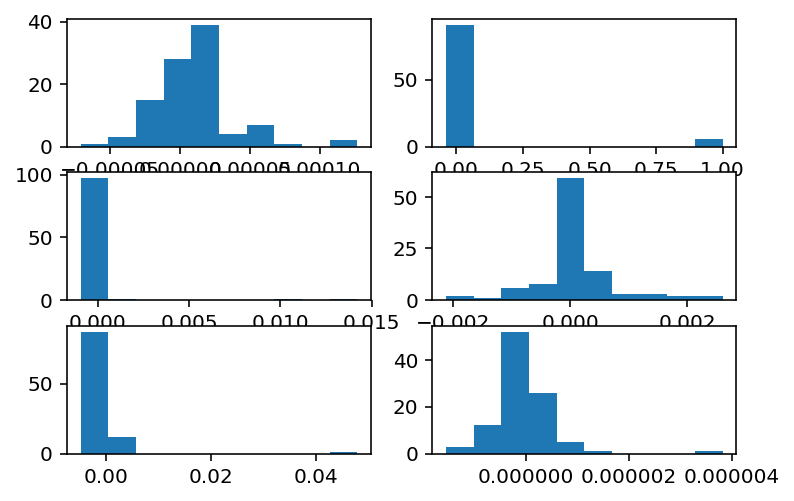

In [57]:
# Draw a random parameter combo to test with.
n = 100
dm0_diff = np.zeros(n)
dalpha_diff = np.zeros(n)
dbeta_diff = np.zeros(n)
dtau_diff = np.zeros(n)
dt0_diff = np.zeros(n)
dsigma_diff = np.zeros(n)
for p in range(n):
    test_x = [abounds[i][0] + x * (abounds[i][1] - abounds[i][0]) for i, x in enumerate(np.random.rand(6))]

    # Check that every derivative expression is close to finite difference.
    teps = 1e-10

    xp = list(test_x)
    xp[0] += teps
    exactd = dlogp_dm0(test_x, test_times, test_mags, test_errs)
    dm0_diff[p] = (exactd - (
        analytic_f(test_x, test_times, test_mags, test_errs) - analytic_f(
            xp, test_times, test_mags, test_errs)) / teps) / exactd

    xp = list(test_x)
    xp[1] += teps
    exactd = dlogp_dalpha(test_x, test_times, test_mags, test_errs)
    dalpha_diff[p] = (exactd - (
        analytic_f(test_x, test_times, test_mags, test_errs) - analytic_f(
            xp, test_times, test_mags, test_errs)) / teps) / exactd

    xp = list(test_x)
    xp[2] += teps
    exactd = dlogp_dbeta(test_x, test_times, test_mags, test_errs)
    dbeta_diff[p] = (exactd - (
        analytic_f(test_x, test_times, test_mags, test_errs) - analytic_f(
            xp, test_times, test_mags, test_errs)) / teps) / exactd

    xp = list(test_x)
    xp[3] += teps
    exactd = dlogp_dtau(test_x, test_times, test_mags, test_errs)
    dtau_diff[p] = (exactd - (
        analytic_f(test_x, test_times, test_mags, test_errs) - analytic_f(
            xp, test_times, test_mags, test_errs)) / teps) / exactd

    xp = list(test_x)
    xp[4] += teps
    exactd = dlogp_dt0(test_x, test_times, test_mags, test_errs)
    dt0_diff[p] = (exactd - (
        analytic_f(test_x, test_times, test_mags, test_errs) - analytic_f(
            xp, test_times, test_mags, test_errs)) / teps) / exactd

    xp = list(test_x)
    xp[5] += teps
    exactd = dlogp_dsigma(test_x, test_times, test_mags, test_errs)
    dsigma_diff[p] = (exactd - (
        analytic_f(test_x, test_times, test_mags, test_errs) - analytic_f(
            xp, test_times, test_mags, test_errs)) / teps) / exactd

plt.subplot(321)
plt.hist(dm0_diff[~np.isnan(dm0_diff)]);
plt.subplot(322)
plt.hist(dalpha_diff[~np.isnan(dalpha_diff)]);
plt.subplot(323)
plt.hist(dbeta_diff[~np.isnan(dbeta_diff)]);
plt.subplot(324)
plt.hist(dtau_diff[~np.isnan(dtau_diff)]);
plt.subplot(325)
plt.hist(dt0_diff[~np.isnan(dt0_diff)]);
plt.subplot(326)
plt.hist(dsigma_diff[~np.isnan(dsigma_diff)]);

Which derivatives seem to have the least accurate finite differences? Why?

## Problem 3

Now we have an analytical function with analytical derivatives that should be accurate to near-machine precision. 

** Problem 3a **

First, let's optimize our function using `differential_evolution`, as we did above with the MOSFiT output, without using the derivatives we have constructed (as `differential_evolution` does not use them).

In [58]:
import scipy

times0 = np.array(times) - min(times)
results = scipy.optimize.differential_evolution(analytic_f, bounds=abounds, args=(
    times0, mags, errs))
best_x = results.x

print('All done! Best score: `{}`, took `{}` function evaluations.'.format(results.fun, results.nfev))

All done! Best score: `-7.11806171578296`, took `13136` function evaluations.


Now plot the result:

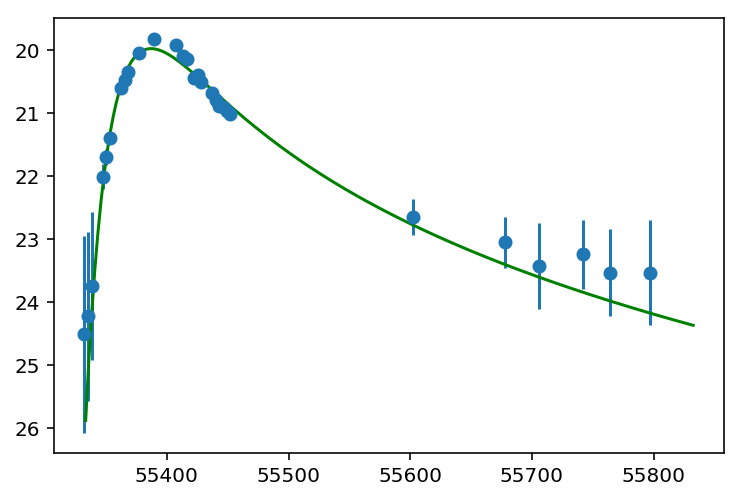

In [59]:
mtimes3 = np.linspace(1, 500, 200)
mmags3 = analytic_m(best_x, mtimes3)
mtimes3 += min(times)

plt.errorbar(times, mags, yerr=errs, fmt='o')
plt.plot(mtimes3, mmags3, c='g')
plt.gca().invert_yaxis()
plt.show()

How good is the approximation?

** Problem 3b **

Let's minimize using the `basinhopping` algorithm now, again not using our derivatives.

In [ ]:
times0 = np.array(times) - min(times)
results = scipy.optimize.basinhopping(  # complete
best_x = results.x

print('All done! Best score: `{}`, took `{}` function evaluations.'.format(results.fun, results.nfev))

This algorithm, which depends on finite differencing, seems to have taken more function evaluations than `differential_evolution`. Let's give it some help: construct a jacobian using the derivative functions defined above.

*Hint: mind the sign of the Jacobian since we are **minimizing** the function.*

In [ ]:
def jac(x, tt, mm, vv):
    m0, alpha, beta, tau, t0, sigma = tuple(x)
    t = np.array(tt)
    m = np.array(mm)
    v = np.array(vv)
    
    # complete
    
    return jac

results = scipy.optimize.basinhopping(  # complete
best_x = results.x

print('All done! Best score: `{}`, took `{}` function evaluations.'.format(results.fun, results.nfev))

# plot the resulting fit

If all went well, the jacobian version of the optimization should have taken ~8x fewer function evaluations. But is it faster?

**Problem 3c**

Compute how many times the Jacobian was called, and estimate how expensive the Jacobian is to compute relative to the objective function. How does this compare to the run that only used finite differencing?

In [ ]:
global jcount
jcount = 0

# complete

Can you think of a reason why using the Jacobian version may be preferable, even if it is slower?

## Challenge Problem(s)

**Select one (or more) of the following:**

- Fit a different event using either MOSFiT or the analytical formula. Any supernova can be loaded by name from the internet via the `fetch` method of the `Fetcher` class. Examples: SN1987A, SN2011fe, PTF09ge. If you are using the analytical model, exclude all but one of the bands in the dataset.
- Optimize the Jacobian function to reuse common functions that are shared between each derivative component (example: $1 - e^{((t + t_0)/\tau)}$ appears frequently in the expressions, it only needs to be computed once).
- Sample the posterior in a Monte Carlo framework (using priors of your choice). Samplers like `emcee` are versatile and work even when derivatives aren't available, but we **do** have derivatives, so more powerful methods like Hamiltonian MCMC are available to us. A simple HMC for our purposes is available via `pip install pyhmc`, see the README for instructions on how to construct the input function: https://github.com/rmcgibbo/pyhmc. Plot the resulting samples using the `corner` package.

In [ ]:
from pyhmc import hmc
# complete

## Concluding questions

- What did we learn from fitting the analytic model about the **physics** of the disruption?
- Does the analytic function have utility for generating simulated data?
- Where else might the analytic function have a use?